In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import geopandas as gpd
import contextily as ctx
import os
from shapely.geometry import Point
from time import time

sns.set()

In [2]:
def plot_barh(series, height=6, width=8, title=''):
    f, ax = plt.subplots(1, figsize=(width, height))
    series.plot(kind='barh', ax=ax, color='gray')
    ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_title(title, fontsize=16)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

## Load Teranet data

In [3]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
t = time()

df = pd.read_csv(teranet_path + '4_Teranet_lu_predict_3c.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 94.57 seconds (1.58 minutes)
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'pric

## Land use predicted based on all features

In [5]:
mask1 = df['lucr_predict'].notnull()
s = df[mask1]

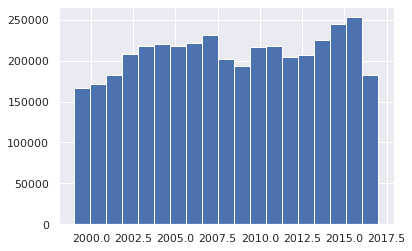

In [7]:
s['year'].hist(bins=19)

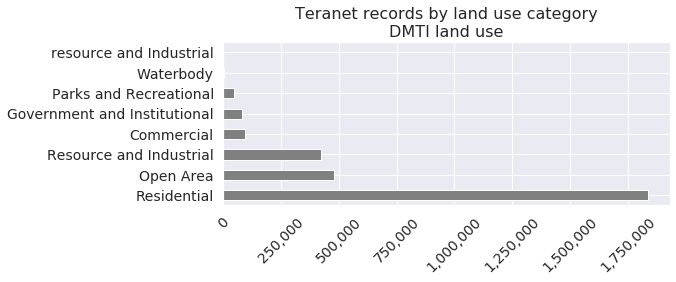

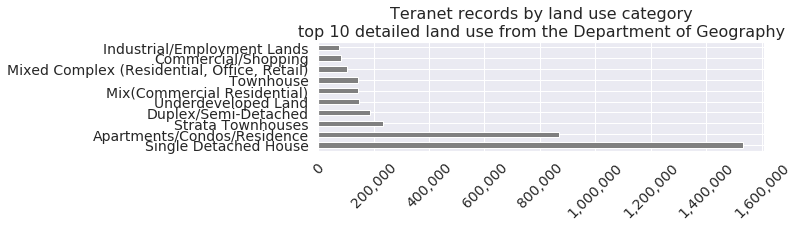

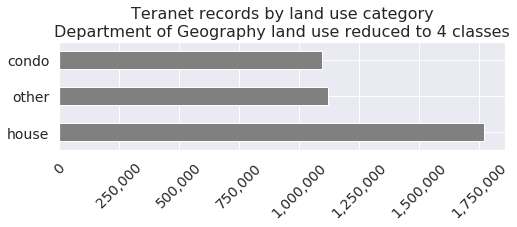

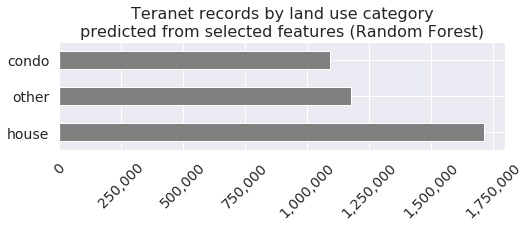

In [11]:
common_title = "Teranet records by land use category"
title = common_title + "\nDMTI land use"
plot_barh(s['dmti_lu'].value_counts(), title=title, height=3)

title = common_title + "\ntop 10 detailed land use from the Department of Geography"
plot_barh(s['code'].value_counts().head(10), title=title, height=2)

title = common_title + "\nDepartment of Geography land use reduced to 4 classes"
plot_barh(s['lucr'].value_counts(), title=title, height=2)

title =  common_title + "\npredicted from selected features (Random Forest)"
plot_barh(s['lucr_predict'].value_counts(), title=title, height=2)

In [10]:
s['lucr'].value_counts().sort_index() - s['lucr_predict'].value_counts().sort_index()

condo     1448
house    55195
other   -56643
dtype: int64

### Join geometry from x and y attributes

### Pick a target point

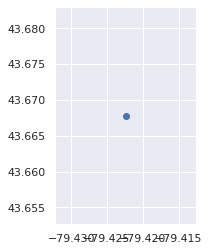

In [12]:
target_point = pd.DataFrame({'target_point': 1}, index=range(1))
target_point['geometry'] = Point([-79.422409, 43.6678197])
target_point_gdf = gpd.GeoDataFrame(target_point, geometry='geometry')
target_point_gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
target_point_gdf.plot();

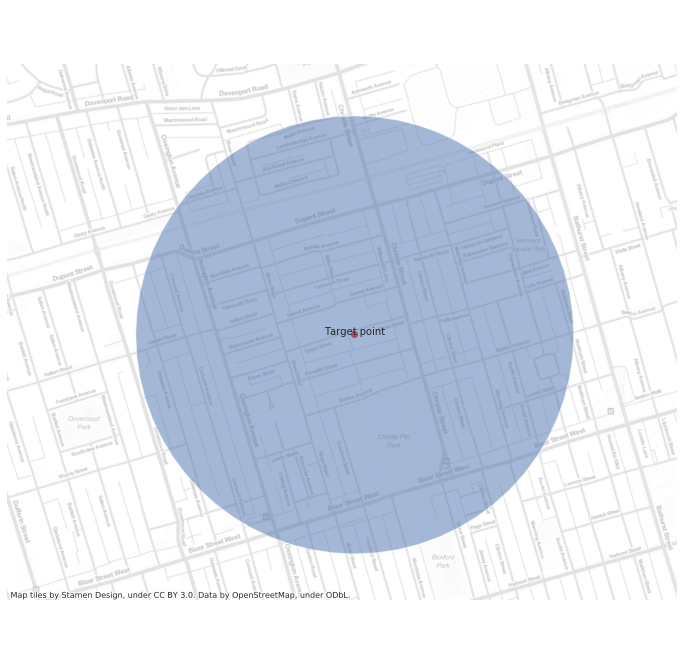

In [13]:
buffer_size = 1000     # size of buffer to draw around the target point, in meters

buffer_gdf = gpd.GeoDataFrame(target_point_gdf.to_crs(epsg=3857).buffer(buffer_size))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
buffer_gdf.crs = {'init': 'epsg:3857'}
buffer_gdf = buffer_gdf.to_crs(epsg=4326)

f, ax = plt.subplots(1, figsize=(12, 12))
target_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE,
                alpha=0.25)
ax.text(target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].x,
        target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].y,
        "Target point", fontsize=10, ha='center')
ax.set_axis_off()
plt.axis('equal')
plt.show()

### Take Teranet subset

In [14]:
min_year = 2012
max_year = 2013
s = df.query('year >= @min_year & year <= @max_year')
print("{0:,} records in the subset from {1} to {2}.".format(len(s), min_year, max_year))

413,027 records in the subset from 2012 to 2013.


In [15]:
# combine values in columns 'x' and 'y' into a POINT geometry object
t = time()
geometry = [Point(xy) for xy in zip(s['x'], s['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
gdf = gpd.GeoDataFrame(s, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(gdf.shape[0], gdf.shape[1]) + 
      "\n-- Column names:\n", gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")


----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 6.72 seconds (0.11 minutes)
with 413,027 rows
and 80 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pc

### Perform spatial join of the buffer with a Teranet subset

In [16]:
gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [17]:
buffer_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [18]:
t = time()
sgdf = gpd.sjoin(gdf, buffer_gdf, how='inner', op='within')
elapsed = time() - t
print('{0:,} transactions occured from {1} to {2} within the boundary of the buffer.'.
     format(len(sgdf), min_year, max_year))
print("Saved in a new GeoDataFrame. Took {0:,.2f} seconds ({1:,.2f} minutes)."
      .format(elapsed, elapsed / 60))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


282 transactions occured from 2012 to 2013 within the boundary of the buffer.
Saved in a new GeoDataFrame. Took 17.10 seconds (0.28 minutes).


Took 2.16 seconds (0.04 minutes) to plot


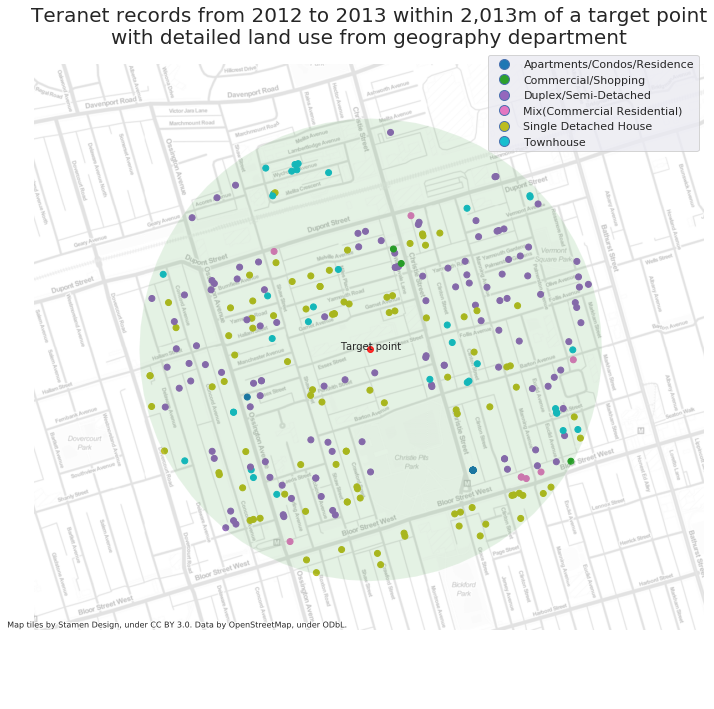

In [19]:
t = time()

# generate figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# plot the subset, target point and the buffer
sgdf.dropna(subset=['code']).to_crs(epsg=3857)\
    .plot(ax=ax, column='code', categorical=True, legend=True)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
target_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ax.text(target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].x,
        target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].y,
        "Target point", fontsize=10, ha='center')

# add basemap
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE,
                alpha=0.25)

# set axis parameters
ax.set_title("Teranet records from {0} to {1} within {1:,}m of a target point"
             "\nwith detailed land use from geography department".format(min_year, max_year, buffer_size),
            fontsize=20)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = sgdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)

elapsed = time() - t
print("Took {0:,.2f} seconds ({1:,.2f} minutes) to plot".format(elapsed, elapsed / 60))
plt.savefig('results/maps/target_point_lugeo.png', dpi=400)

Took 2.31 seconds (0.04 minutes) to plot


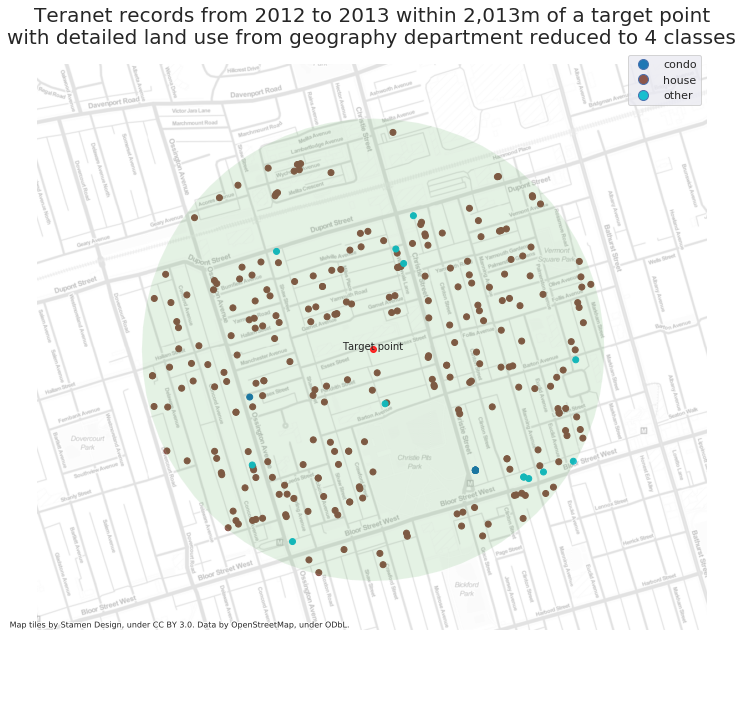

In [20]:
col = 'lucr'

t = time()

# generate figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# plot the subset, target point and the buffer
sgdf.dropna(subset=[col]).to_crs(epsg=3857)\
    .plot(ax=ax, column=col, categorical=True, legend=True)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
target_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ax.text(target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].x,
        target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].y,
        "Target point", fontsize=10, ha='center')

# add basemap
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE,
                alpha=0.25)

# set axis parameters
ax.set_title("Teranet records from {0} to {1} within {1:,}m of a target point"
             "\nwith detailed land use from geography department reduced to 4 classes"
             .format(min_year, max_year, buffer_size), fontsize=20)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = sgdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)

elapsed = time() - t
print("Took {0:,.2f} seconds ({1:,.2f} minutes) to plot".format(elapsed, elapsed / 60))
plt.savefig('results/maps/target_point_lucr_predict.png', dpi=400)

Took 2.26 seconds (0.04 minutes) to plot


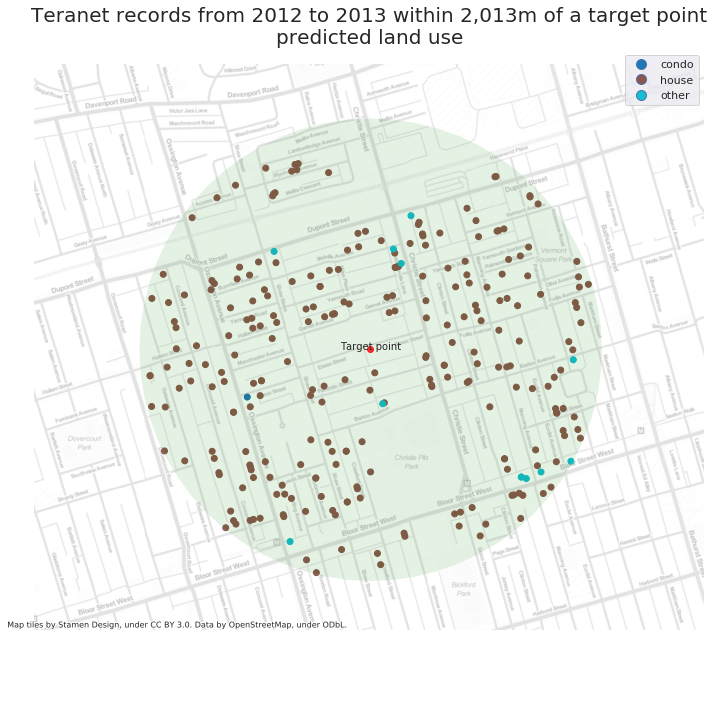

In [21]:
col = 'lucr_predict'

t = time()

# generate figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# plot the subset, target point and the buffer
sgdf.dropna(subset=[col]).to_crs(epsg=3857)\
    .plot(ax=ax, column=col, categorical=True, legend=True)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
target_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ax.text(target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].x,
        target_point_gdf.to_crs(epsg=3857).loc[0, 'geometry'].y,
        "Target point", fontsize=10, ha='center')

# add basemap
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE,
                alpha=0.25)

# set axis parameters
ax.set_title("Teranet records from {0} to {1} within {1:,}m of a target point"
             "\npredicted land use"
             .format(min_year, max_year, buffer_size), fontsize=20)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = sgdf.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)

elapsed = time() - t
print("Took {0:,.2f} seconds ({1:,.2f} minutes) to plot".format(elapsed, elapsed / 60))
plt.savefig('results/maps/target_point_lucr_predict.png', dpi=400)

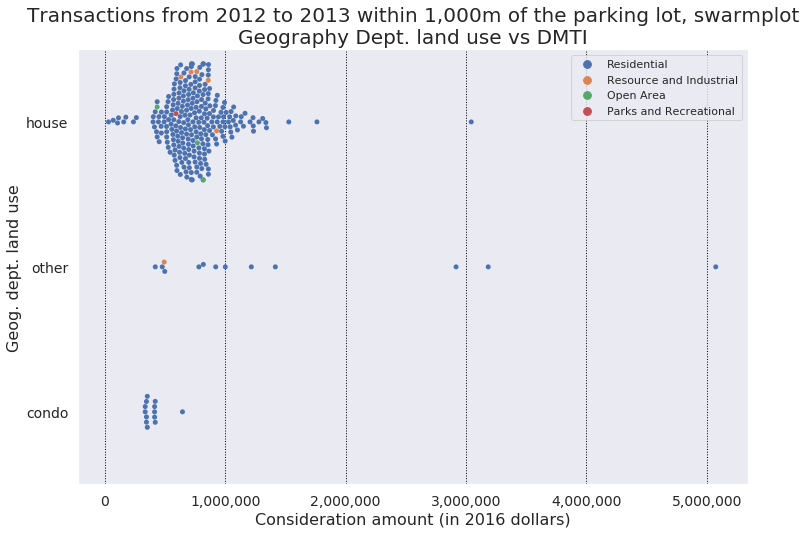

In [27]:
f, ax = plt.subplots(1, figsize=(12, 8))

sns.swarmplot(data=sgdf, y='lucr', x='price_2016', hue='dmti_lu', ax=ax)

# set axis parameters
ax.set_ylabel("Geog. dept. land use", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions from {0} to {1} within {2:,}m of the parking lot, swarmplot".format(min_year, max_year, 
                                                                                               buffer_size) +
             "\nGeography Dept. land use vs DMTI", fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='best')
ax.grid(axis='x', color='black', linestyle=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
#plt.savefig('results/maps/teranet_parking_swarmplot.png', dpi=300, bbox_inches='tight')

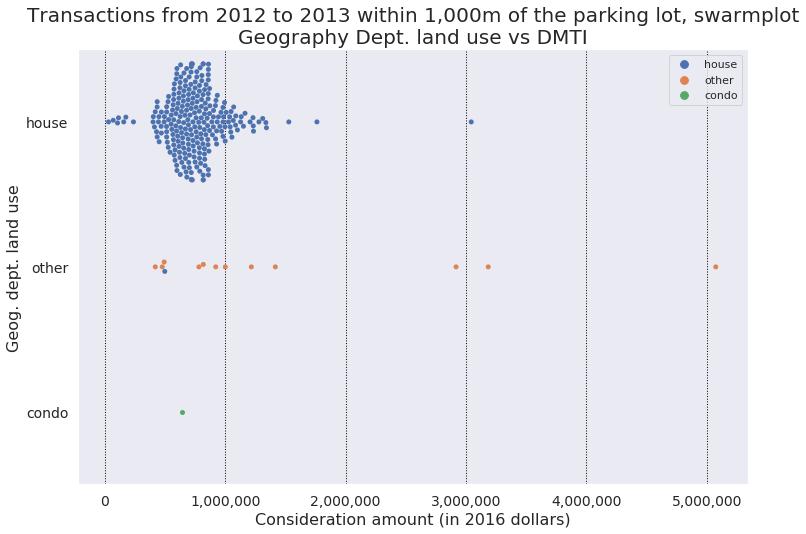

In [28]:
f, ax = plt.subplots(1, figsize=(12, 8))

sns.swarmplot(data=sgdf, y='lucr', x='price_2016', hue='lucr_predict', ax=ax)

# set axis parameters
ax.set_ylabel("Geog. dept. land use", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions from {0} to {1} within {2:,}m of the parking lot, swarmplot".format(min_year, max_year, 
                                                                                               buffer_size) +
             "\nGeography Dept. land use vs DMTI", fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='best')
ax.grid(axis='x', color='black', linestyle=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
#plt.savefig('results/maps/teranet_parking_swarmplot.png', dpi=300, bbox_inches='tight')

## Validation subset \#2

In [115]:
year = 2015
s = df.query('year == @year')
print("{0:,} records in the subset from {1}.".format(len(s), year))

244,787 records in the subset from 2015.


In [117]:
mask1 = s['lucr_predict'] != s['lucr']
s.loc[mask1, 'lucr_pred_error'] = True
s['lucr_pred_error'] = s['lucr_pred_error'].fillna(False)
s['lucr_pred_error'].value_counts()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


False    215561
True      29226
Name: lucr_pred_error, dtype: int64

In [118]:
error_count = s.groupby('dauid')['lucr_pred_error'].sum().sort_values(ascending=False)
error_count.name = 'error_count'

error_df = pd.DataFrame(error_count)

record_count = s.groupby('dauid')['lucr_pred_error'].count()
record_count.name = 'record_count'

error_df = error_df.join(record_count)
error_df['error_perc'] = error_df['error_count'] / error_df['record_count']
error_df = error_df.reset_index()
error_df

,dauid,error_count,record_count,error_perc
0,35201453,1310.0,1588,0.824937
1,35204579,1285.0,1457,0.881949
2,35211034,1268.0,1271,0.997640
3,35202140,1153.0,1215,0.948971
4,35204898,987.0,989,0.997978
...,...,...,...,...
8846,35204592,0.0,189,0.000000
8847,35204593,0.0,45,0.000000
8848,35204594,0.0,39,0.000000
8849,35204595,0.0,95,0.000000


In [119]:
focus_da = 35201453
mask1 = s['dauid'] == focus_da
s.loc[mask1, 'lucr'].value_counts().sort_index() - s.loc[mask1, 'lucr_predict'].value_counts().sort_index()

condo   -1310
house       0
other    1310
dtype: int64

In [120]:
focus_da = 35204579
mask1 = s['dauid'] == focus_da
s.loc[mask1, 'lucr'].value_counts().sort_index() - s.loc[mask1, 'lucr_predict'].value_counts().sort_index()

condo    1285
other   -1285
dtype: int64

## Join error counts to DA geometry and map results

In [56]:
census_path = data_path + 'census/da_census_income_shapefile/'
os.listdir(census_path)

['da_census_income.prj',
 'da_census_income.cpg',
 'da_census_income.dbf',
 'da_census_income.shp',
 'da_census_income.shx']

In [57]:
da_gdf = gpd.read_file(census_path)

In [ ]:
da_gdf['DAUID'] = da_gdf['DAUID'].astype('int')

In [ ]:
da_error_gdf = pd.merge(da_gdf, error_df, left_on='DAUID', right_on='dauid')

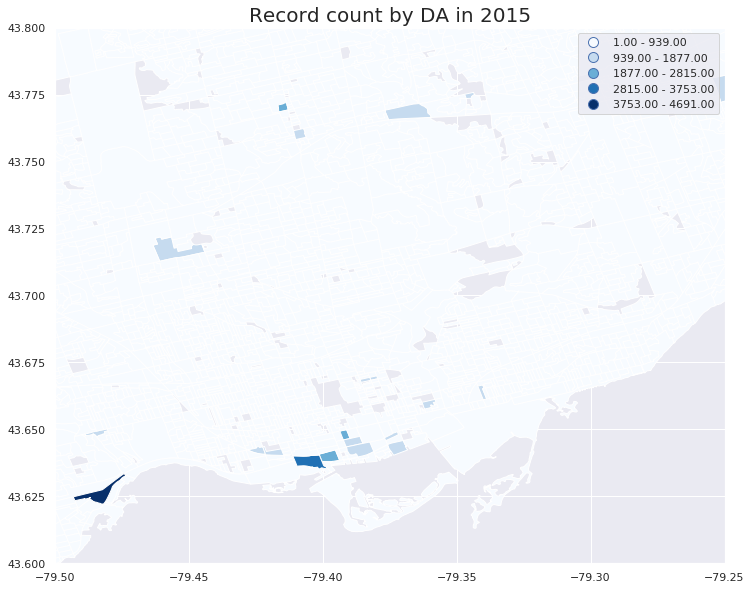

In [155]:
ax = da_error_gdf.plot(column='record_count', scheme='equal_interval', figsize=(12, 12), legend=True, cmap='Blues')
ax.set_title('Record count by DA in {0}'.format(year), fontsize=20)
ax.set_xlim(-79.5, -79.25)
ax.set_ylim(43.6, 43.8)
plt.show()

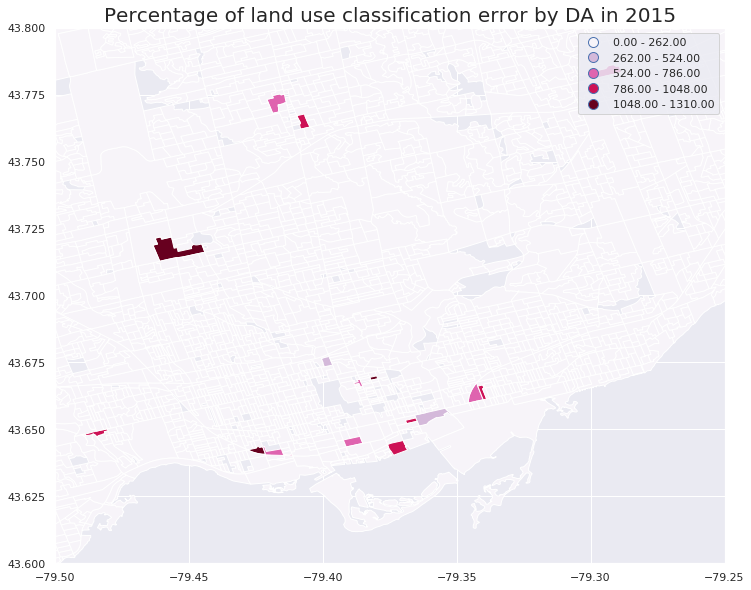

In [194]:
da_error_gdf = pd.merge(da_gdf, error_df, left_on='DAUID', right_on='dauid')
ax = da_error_gdf.plot(column='error_count', scheme='equal_interval', figsize=(12, 12), legend=True, cmap='PuRd')
ax.set_title('Percentage of land use classification error by DA in {0}'.format(year), fontsize=20)
ax.set_xlim(-79.5, -79.25)
ax.set_ylim(43.6, 43.8)
plt.show()

In [184]:
top10_err = da_error_gdf.set_index('DAUID')['error_count'].sort_values(ascending=False).head(10)

In [199]:
top10_err = top10_err.drop(35211034)

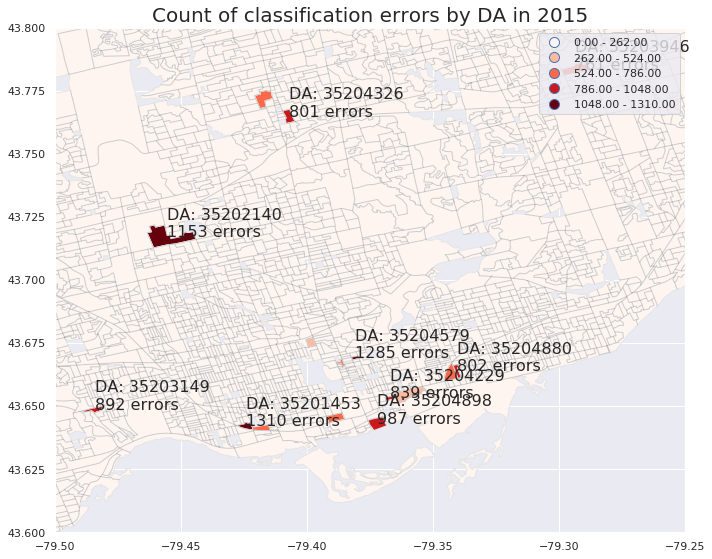

In [240]:
da_error_gdf = pd.merge(da_gdf, error_df, left_on='DAUID', right_on='dauid')
ax = da_error_gdf.plot(column='error_count', scheme='equal_interval', 
                       figsize=(10, 10), legend=True, cmap='Reds')
da_error_gdf.plot(edgecolor='black', facecolor="None", alpha=0.1, ax=ax)
ax.set_title('Count of classification errors by DA in {0}'.format(year), fontsize=20)
for daid, err_count in top10_err.iteritems():
    mask1 = da_error_gdf['DAUID'] == daid
    
    ax.text(da_error_gdf.loc[mask1, 'geometry'].centroid.x, da_error_gdf.loc[mask1, 'geometry'].centroid.y,
            "DA: {0}\n{1:.0f} errors".format(daid, err_count), fontsize=16)
ax.set_xlim(-79.5, -79.25)
ax.set_ylim(43.6, 43.8)
plt.tight_layout()
plt.savefig("error_map_2015.png")

In [ ]:
cols = ['price_2016', 'unitno', 'street_number', 'street_name', 'street_designation',
        'code', 'lucr', 'dmti_lu', 'lucr_predict']

In [ ]:
focus_da = 35201453

In [244]:
mask1 = s['dauid'] == focus_da
mask2 = s['lucr'] != s['lucr_predict']
s.loc[mask1 & mask2, 'street_name'].value_counts()

Lisgar            1293
Lisgar Street       13
Abell                3
Lisgar  Street       1
Name: street_name, dtype: int64

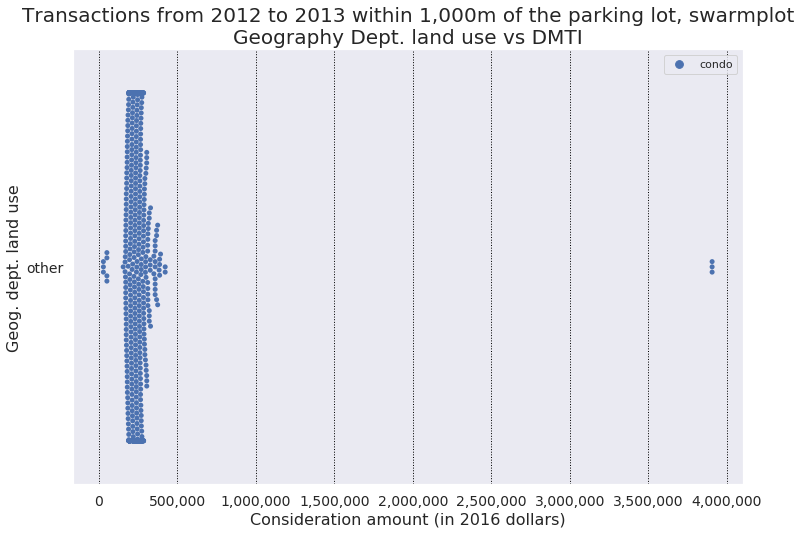

In [245]:
f, ax = plt.subplots(1, figsize=(12, 8))

sns.swarmplot(data=s[mask1 & mask2], y='lucr', x='price_2016', hue='lucr_predict', ax=ax)

# set axis parameters
ax.set_ylabel("Geog. dept. land use", fontsize=16)
ax.set_xlabel("Consideration amount (in 2016 dollars)", fontsize=16)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions from {0} to {1} within {2:,}m of the parking lot, swarmplot".format(min_year, max_year, 
                                                                                               buffer_size) +
             "\nGeography Dept. land use vs DMTI", fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='best')
ax.grid(axis='x', color='black', linestyle=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
#plt.savefig('results/maps/teranet_parking_swarmplot.png', dpi=300, bbox_inches='tight')

In [205]:
# combine values in columns 'x' and 'y' into a POINT geometry object
t = time()
geometry = [Point(xy) for xy in zip(s['x'], s['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
valgdf = gpd.GeoDataFrame(s, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(valgdf.shape[0], valgdf.shape[1]) + 
      "\n-- Column names:\n", valgdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
valgdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")


----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 4.45 seconds (0.07 minutes)
with 244,787 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pc

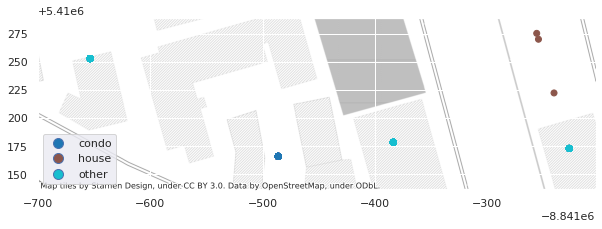

In [228]:
mask1 = valgdf['dauid'] == focus_da
f, ax = plt.subplots(1, figsize=(10, 10))
valgdf[mask1].to_crs(epsg=3857).plot(column='lucr', ax=ax, legend=True)
#da_centroid = da_gdf.set_index('DAUID').to_crs(epsg=3857).loc[focus_da, 'geometry'].centroid
#center_x = da_centroid.x
#center_y = da_centroid.y
spread = 0.01
#ax.set_xlim(center_x - spread, center_x + spread)
#ax.set_ylim(center_y - spread, center_y + spread)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND)
plt.show()

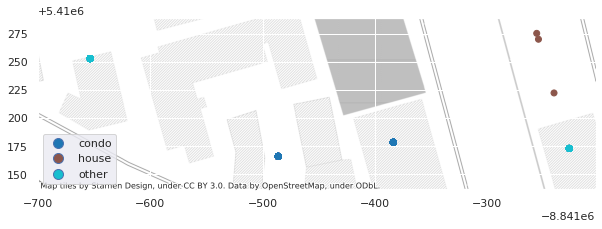

In [232]:
mask1 = valgdf['dauid'] == focus_da
f, ax = plt.subplots(1, figsize=(10, 10))
valgdf[mask1].to_crs(epsg=3857).plot(column='lucr_predict', ax=ax, legend=True)
#da_centroid = da_gdf.set_index('DAUID').to_crs(epsg=3857).loc[focus_da, 'geometry'].centroid
#center_x = da_centroid.x
#center_y = da_centroid.y
spread = 0.01
#ax.set_xlim(center_x - spread, center_x + spread)
#ax.set_ylim(center_y - spread, center_y + spread)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND)
plt.show()